
## Importing the relevant libraries

## Loading the images

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from tqdm.notebook import tqdm
tqdm.pandas()
import cv2, warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Add, Dropout, LSTM, TimeDistributed, Embedding, RepeatVector, Concatenate, Bidirectional, Convolution2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
img_path = '/kaggle/input/flickr8k/Images/'
images = glob(img_path+'*.jpg')
images[:5]

['/kaggle/input/flickr8k/Images/3226254560_2f8ac147ea.jpg',
 '/kaggle/input/flickr8k/Images/214543992_ce6c0d9f9b.jpg',
 '/kaggle/input/flickr8k/Images/2366643786_9c9a830db8.jpg',
 '/kaggle/input/flickr8k/Images/3368819708_0bfa0808f8.jpg',
 '/kaggle/input/flickr8k/Images/2190227737_6e0bde2623.jpg']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
len(images)

8091

## Loading the captions

In [ ]:
captions = open('/kaggle/input/flickr8k/captions.txt','rb').read().decode('utf-8').split('\n')
captions[:5]

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .']

In [ ]:
len(captions)

40457

## Visualizing images along with their captions

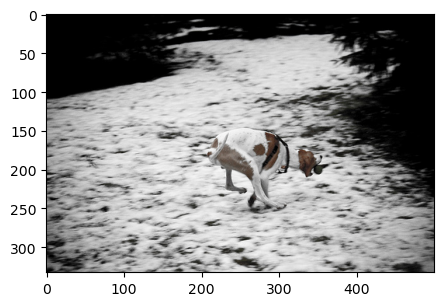

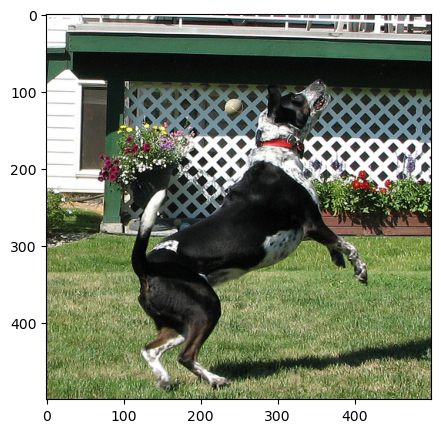

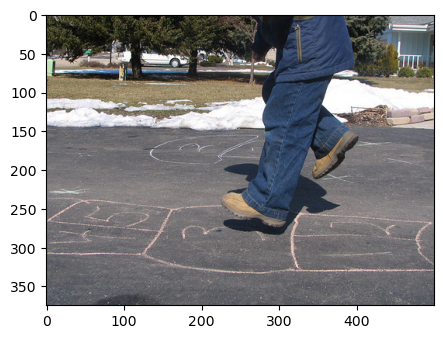

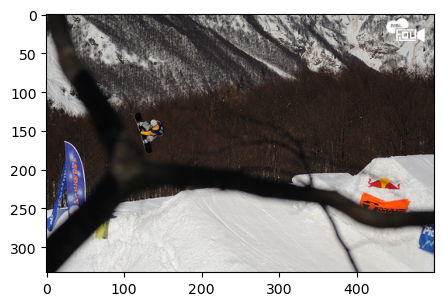

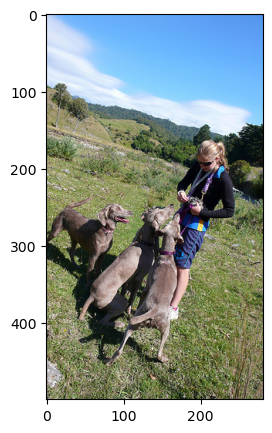

In [ ]:
for i in range(5):
    plt.figure(figsize=(5,5))
    img = cv2.imread(images[i])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img);

## Downloading the ResNet50 inception model

In [ ]:
inception_model = ResNet50(include_top=True)
inception_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
last = inception_model.layers[-2].output # Output of the penultimate layer of ResNet model
model = Model(inputs=inception_model.input,outputs=last)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

## Extracting features from images

In [ ]:
img_features = {}
count = 0

for img_path in tqdm(images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224)) # ResNet model requires images of dimensions (224,224,3)
    img = img.reshape(1,224,224,3) # Reshaping image to the dimensions of a single image
    features = model.predict(img).reshape(2048,) # Feature extraction from images
    img_name = img_path.split('/')[-1] # Extracting image name
    img_features[img_name] = features
    count += 1
    # Fetching the features of only 1500 images as using more than 1500 images leads to overloading memory issues
    if count == 1500:
        break
    if count % 50 == 0:
        print(count)

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 30ms/step
50
1/1 [==============================] - 0s 32ms/step
100
1/1 [==============================] - 0s 31ms/step
150
1/1 [==============================] - 0s 32ms/step
200
1/1 [==============================] - 0s 30ms/step
250
1/1 [==============================] - 0s 34ms/step
300
1/1 [==============================] - 0s 31ms/step
350
1/1 [==============================] - 0s 35ms/step
400
1/1 [==============================] - 0s 35ms/step
450
1/1 [==============================] - 0s 32ms/step
500
1/1 [==============================] - 0s 32ms/step
550
1/1 [==============================] - 0s 32ms/step
600
1/1 [==============================] - 0s 31ms/step
650
1/1 [==============================] - 0s 32ms/step
700
1/1 [==============================] - 0s 31ms/step
750
1/1 [==============================] - 0s 33ms/step
800
1/1 [==============================] - 0s 37ms/step
850
1/1 [==============================] - 0s 30ms/st

In [ ]:
len(img_features)

1500

## Preprocessing the captions text

In [ ]:
captions = captions[1:]
captions[:5]

['1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .']

In [ ]:
captions[8].split(',')[1]

'Two dogs of different breeds looking at each other on the road .'

In [ ]:
captions_dict = {}

for cap in captions:
    try:
        img_name = cap.split(',')[0]
        caption = cap.split(',')[1]
        # Each image has 5 captions
        if img_name in img_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption] # Storing the first caption
            else:
                captions_dict[img_name].append(caption) # Adding the remaining captions
    except:
        break

In [ ]:
len(captions_dict)

1500

In [ ]:
print(captions_dict)

{'1002674143_1b742ab4b8.jpg': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting in front of a rainbow painting .', 'Young girl with pigtails painting outside in the grass .'], '102351840_323e3de834.jpg': ['A man drilling a hole in the ice .', 'A man is drilling through the frozen ice of a pond .', 'A person in the snow drilling a hole in the ice .', 'A person standing on a frozen lake .', 'Two men are ice fishing .'], '1024138940_f1fefbdce1.jpg': ['Two different breeds of brown and white dogs play on the beach .', 'Two dogs are making a turn on a soft sand beach .', 'Two dogs playing in the sand at the beach .', 'Two dogs playing together on a beach .', 'Two large tan dogs play along a sandy beach .'], '103205630_682ca7285b.jpg': ['A t

In [ ]:
def text_preprocess(text):
    modified_text = text.lower() # Converting text to lowercase
    modified_text = 'startofseq ' + modified_text + ' endofseq' # Appending the special tokens at the beginning and ending of text
    return modified_text

In [ ]:
# Storing the preprocessed text within the captions dictionary
for key, val in captions_dict.items():
    for item in val:
        captions_dict[key][val.index(item)] = text_preprocess(item)

## Creating vocabulary of the entire text corpus

In [ ]:
count_words = dict()
cnt = 1

for key, val in captions_dict.items(): # Iterating through all images with keys as images and their values as 5 captions
    for item in val: # Iterating through all captions for each image
        for word in item.split(): # Iterating through all words in each caption
            if word not in count_words:
                count_words[word] = cnt
                cnt += 1

In [ ]:
len(count_words) # Vocab size

4031

In [ ]:
# Encoding the text by assigning each word to its corresponding index in the vocabulary i.e. count_words dictionary
for key, val in captions_dict.items():
    for caption in val:
        encoded = []
        for word in caption.split():
            encoded.append(count_words[word])
        captions_dict[key][val.index(caption)] = encoded

In [ ]:
# Determining the maximum possible length of text within the entire captions text corpus
max_len = -1

for key, value in captions_dict.items():
    for caption in value:
        if max_len < len(caption):
            max_len = len(caption)

In [ ]:
max_len

34

In [ ]:
vocab_size = len(count_words) # Vocab size is the total number of words present in count_words dictionary
vocab_size

4031

In [ ]:
imgname_list = list(img_features.keys())

# Convert dictionary values to a list
imgfeature_list = list(img_features.values())

[array([6.2825590e-01, 7.8491384e-01, 5.6670231e-01, ..., 8.9139175e-01,
        4.5790963e-05, 0.0000000e+00], dtype=float32),
 array([0.4622053 , 0.29161948, 0.06892866, ..., 0.5730685 , 0.        ,
        0.28785333], dtype=float32),
 array([0.8897092 , 0.16498405, 0.03830738, ..., 0.27047187, 0.678552  ,
        0.1524172 ], dtype=float32),
 array([0.49305245, 0.64883024, 0.03944182, ..., 0.49528614, 0.04874273,
        0.        ], dtype=float32),
 array([0.8279501 , 0.        , 0.98436755, ..., 0.12665227, 0.5096806 ,
        2.5331469 ], dtype=float32),
 array([0.24190325, 0.35491422, 0.03130047, ..., 0.        , 0.1282315 ,
        0.13541579], dtype=float32),
 array([0.58560073, 0.05671079, 0.8978798 , ..., 2.3858984 , 0.03280631,
        0.09501775], dtype=float32),
 array([1.4456658 , 1.8188038 , 0.17784952, ..., 0.05116587, 0.        ,
        0.98535496], dtype=float32),
 array([1.293468  , 1.2024974 , 0.7290695 , ..., 0.        , 0.7555333 ,
        0.15819466], dtype=fl

## Building a custom generator function to generate input image features, previously generated text and the text to be generated as output

In [ ]:
def generator(img,caption):
    n_samples = 0
    X = []
    y_input = []
    y_output = []

    for key, val in caption.items():
        for item in val:
            for i in range(1,len(item)):
                X.append(img[key]) # Appending the input image features
                input_seq = [item[:i]] # Previously generated text to be used as input to predict the next word
                output_seq = item[i] # The next word to be predicted as output
                # Padding encoded text sequences to the maximum length
                input_seq = pad_sequences(input_seq,maxlen=max_len,padding='post',truncating='post')[0]
                # One Hot encoding the output sequence with vocabulary size as the total no. of classes
                output_seq = to_categorical([output_seq],num_classes=vocab_size+1)[0]
                y_input.append(input_seq)
                y_output.append(output_seq)

    return X, y_input, y_output

In [ ]:
X, y_in, y_out = generator(img_features,captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(92038, 92038, 92038)

In [ ]:
# Converting input and output into Numpy arrays for faster processing
X = np.array(X)
y_in = np.array(y_in,dtype='float64')
y_out = np.array(y_out,dtype='float64')

In [ ]:
X.shape, y_in.shape, y_out.shape

((92038, 2048), (92038, 34), (92038, 4032))

## Establishing the model architecture

In [ ]:
embedding_len = 128
MAX_LEN = max_len
vocab_size = len(count_words)

# Model for image feature extraction
img_model = Sequential()
img_model.add(Dense(embedding_len,input_shape=(2048,),activation='relu'))
img_model.add(RepeatVector(MAX_LEN))

img_model.summary()

# Model for generating captions from image features
captions_model = Sequential()
captions_model.add(Embedding(input_dim=vocab_size+1,output_dim=embedding_len,input_length=MAX_LEN))
captions_model.add(LSTM(256,return_sequences=True))
captions_model.add(TimeDistributed(Dense(embedding_len)))

captions_model.summary()

# Concatenating the outputs of image and caption models
concat_output = Concatenate()([img_model.output,captions_model.output])
# First LSTM Layer
output = LSTM(units=128,return_sequences=True)(concat_output)
# Second LSTM Layer
output = LSTM(units=512,return_sequences=False)(output)
# Output Layer
output = Dense(units=vocab_size+1,activation='softmax')(output)
# Creating the final model
final_model = Model(inputs=[img_model.input,captions_model.input],outputs=output)
final_model.compile(loss='categorical_crossentropy',optimizer='RMSprop',metrics='accuracy')
final_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 34, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 34, 128)           516096    
                                                                 
 lstm (LSTM)                 (None, 34, 256)           394240    
                            

## Visualizing the model architecture

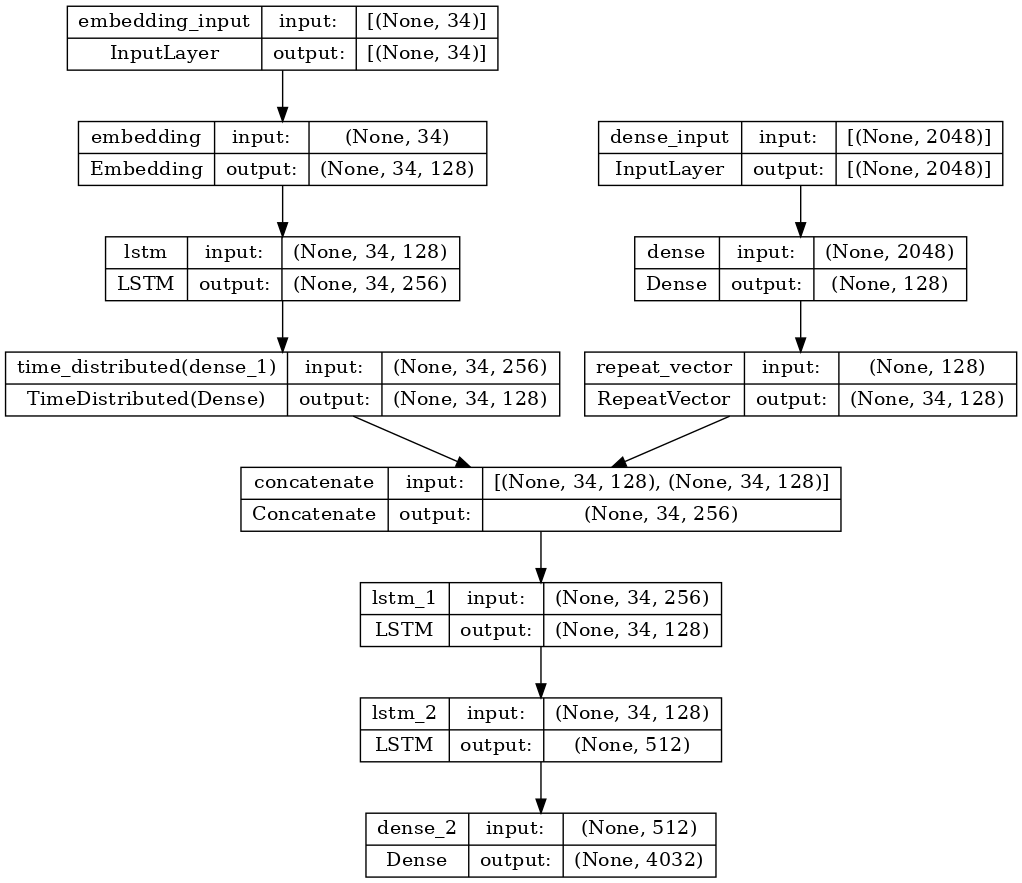

In [ ]:
plot_model(final_model,'model.png',show_shapes=True,dpi=100)

## Model training

In [ ]:
mc = ModelCheckpoint('image_caption_generator.h5',monitor='accuracy',verbose=1,mode='max',save_best_only=True)

final_model.fit([X,y_in],
                y_out,
                batch_size=512,
                callbacks=mc,
                epochs=150)

Epoch 1/150
180/180 [==============================] - ETA: 0s - loss: 5.3440 - accuracy: 0.1133
Epoch 1: accuracy improved from -inf to 0.11327, saving model to image_caption_generator.h5
180/180 [==============================] - 35s 143ms/step - loss: 5.3440 - accuracy: 0.1133
Epoch 2/150
180/180 [==============================] - ETA: 0s - loss: 5.1659 - accuracy: 0.1176
Epoch 2: accuracy improved from 0.11327 to 0.11761, saving model to image_caption_generator.h5
180/180 [==============================] - 18s 98ms/step - loss: 5.1659 - accuracy: 0.1176
Epoch 3/150
180/180 [==============================] - ETA: 0s - loss: 5.0987 - accuracy: 0.1190
Epoch 3: accuracy improved from 0.11761 to 0.11901, saving model to image_caption_generator.h5
180/180 [==============================] - 18s 98ms/step - loss: 5.0987 - accuracy: 0.1190
Epoch 4/150
180/180 [==============================] - ETA: 0s - loss: 5.0201 - accuracy: 0.1199
Epoch 4: accuracy improved from 0.11901 to 0.11986, savi

In [ ]:
# Creating an inverse dictionary with reverse key-value pairs
inverse_dict = {val: key for key,val in count_words.items()}

## Saving the final trained model and the vocabulary dictionary

In [ ]:
final_model.save('image_caption_generator.h5')

In [ ]:
np.save('vocab.npy',count_words)

## Generating sample predictions

In [ ]:
# Custom function for extracting an image and transforming it into an appropriate format
def getImage(idx):
    test_img_path = images[idx]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))
    test_img = np.reshape(test_img,(1,224,224,3))
    return test_img

1/1 [==============================] - 0s 25ms/step


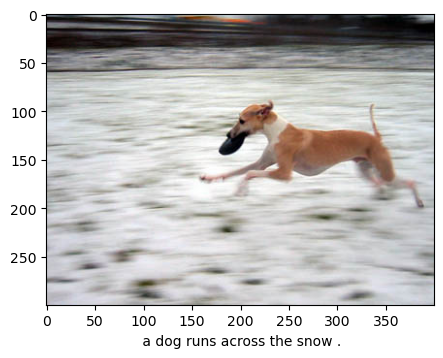

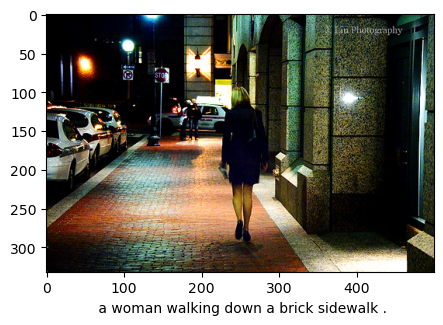

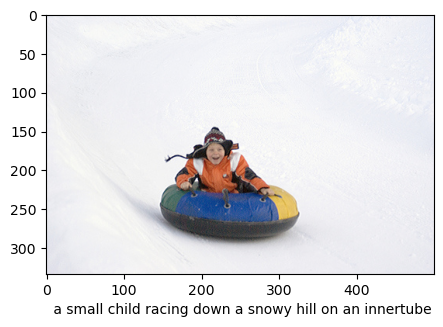

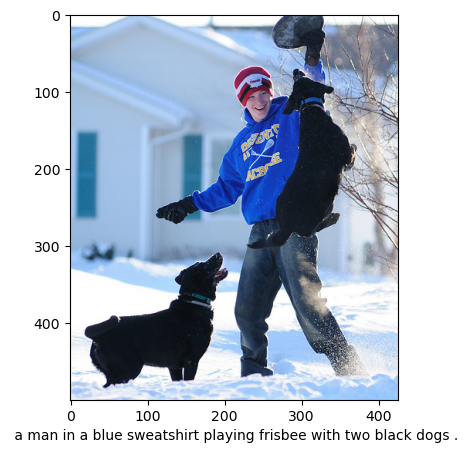

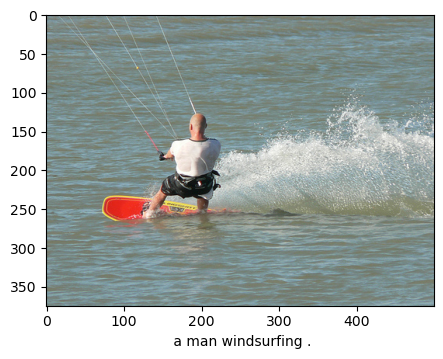

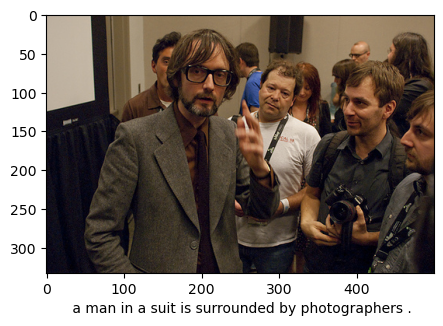

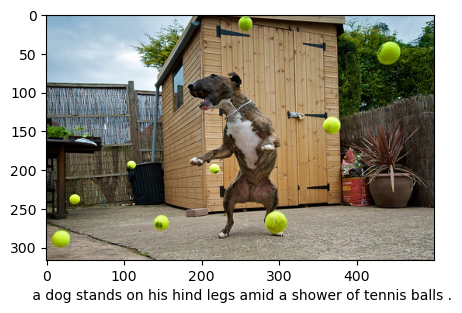

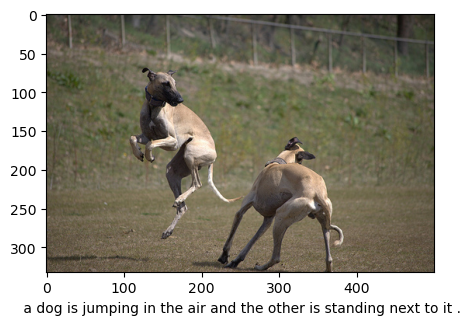

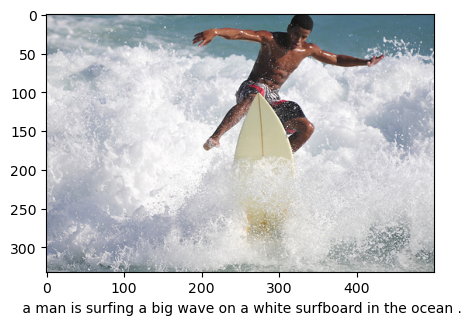

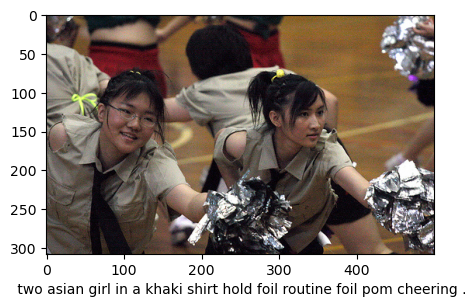

In [ ]:
for i in range(10):
    random_no = np.random.randint(0,1501,(1,1))[0,0]
    if(random_no not in imgname_list ):
        test_feature = model.predict(getImage(random_no)).reshape(1,2048)
        test_img_path = images[random_no]
        test_img = cv2.imread(test_img_path)
        test_img = cv2.cvtColor(test_img,cv2.COLOR_BGR2RGB)
        pred_text = ['startofseq']
        count = 0
        caption = '' # Stores the predicted captions text

        while count < 25:
            count += 1
            # Encoding the captions text with numbers
            encoded = []

            for i in pred_text:
                encoded.append(count_words[i])

            encoded = [encoded]
            # Padding the encoded text sequences to maximum length
            encoded = pad_sequences(encoded,maxlen=MAX_LEN,padding='post',truncating='post')
            pred_idx = np.argmax(final_model.predict([test_feature,encoded])) # Fetching the predicted word index having the maximum probability of occurrence
            sampled_word = inverse_dict[pred_idx] # Extracting the predicted word by its respective index
            # Checking for ending of the sequence
            if sampled_word == 'endofseq':
                break
            caption = caption + ' ' + sampled_word
            pred_text.append(sampled_word)

        plt.figure(figsize=(5,5))
        plt.imshow(test_img)
        plt.xlabel(caption)